In [1]:
pip install numpy pandas matplotlib seaborn tensorflow keras scikit-learn yfinance


In [2]:
import yfinance as yf

# Get user input for cryptocurrency symbol
crypto_symbol = input("Enter cryptocurrency symbol (e.g., BTC-USD, ETH-USD, DOGE-USD): ").upper()

# Download historical data
df = yf.download(crypto_symbol, start="2018-01-01", end="2024-01-01")

# Handle invalid symbols
if df.empty:
    print("❌ Invalid cryptocurrency symbol or no data available.")
else:
    print(f"\n📊 Showing historical data for {crypto_symbol}:\n")
    print(df.head())  # Display first few rows


Enter cryptocurrency symbol (e.g., BTC-USD, ETH-USD, DOGE-USD): ETH-USD
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


📊 Showing historical data for ETH-USD:

Price            Close         High         Low        Open      Volume
Ticker         ETH-USD      ETH-USD     ETH-USD     ETH-USD     ETH-USD
Date                                                                   
2018-01-01  772.640991   782.530029  742.004028  755.757019  2595760128
2018-01-02  884.443970   914.830017  772.346008  772.346008  5783349760
2018-01-03  962.719971   974.471008  868.450989  886.000000  5093159936
2018-01-04  980.921997  1045.079956  946.085999  961.713013  6502859776
2018-01-05  997.719971  1075.390015  956.325012  975.750000  6683149824


In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df["Close"].values.reshape(-1,1))

# Function to Create Sequences
def create_sequences(data, time_step=60):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  # Use past 60 days to predict next day
X, Y = create_sequences(df_scaled)

# Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape for LSTM (samples, time-steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.fit(X_train, Y_train, batch_size=16, epochs=30)


Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0179
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0028
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0024
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0018
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0015
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0017
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0015
Epoch 8/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0015
Epoch 9/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0017
Epoch 10/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0015
Epoch 11/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0011
Epoch 12/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0014
Epoch 13/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0013
Epoch 14/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0012
Epoch 15/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s

In [8]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


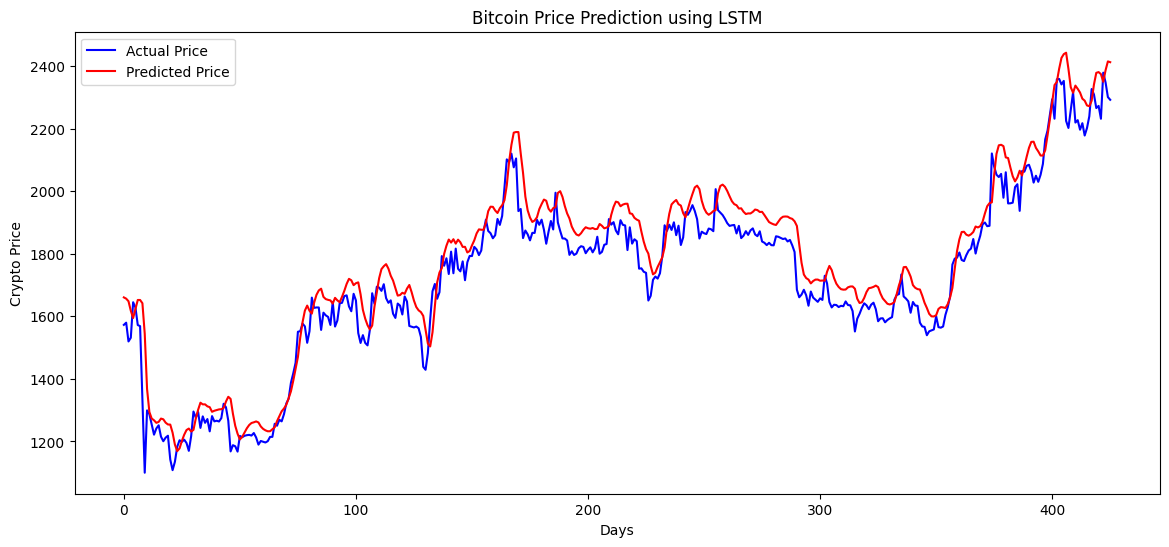

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(Y_test, label="Actual Price", color="blue")
plt.plot(predictions, label="Predicted Price", color="red")
plt.xlabel("Days")
plt.ylabel("Crypto Price")
plt.legend()
plt.title("Bitcoin Price Prediction using LSTM")
plt.show()


In [10]:
import keras.saving
keras.saving.save_model(model, "crypto_model.keras")
